---
title: Design and Impact of Automated Decision Systems
author: Andrew Dean
date: '2025-03-02'
image: "loan-need-a-loan.gif"
description: "Delve into a profit-driven loan approval model. Explore its ethical implications."
code-fold: true
execute:
    warning: false
    message: false
---

### Introduction
This blog tackles a real-world problem: given information about an individual and their specific loan request, should a bank offer this person a loan? I conducted an exploration of the data to determine which features are the best predictors of loan status (whether someone will default or not). Using logistic regression, I determined that person_home_ownership and loan_percent_income were the most predictive features and created a weight vector for a linear score function.

With the goal of maximizing bank profit, I established an optimal threshold value: individuals with scores below this threshold are hypothetically offered loans, while those above are denied. However, as shown in my analysis, a model created solely to maximize profit can lead to disparate impacts across different groups, which will be discussed more at the conclusion of this post. The approval rates vary by age (with older applicants facing much lower approval rates), loan purpose (with medical loans having the lowest approval rates), and income level (with a clear advantage for higher-income applicants). 

While the model is effective at predicting defaults and maximizing profits, these findings raise important questions about fairness and access to credit that financial institutions should consider beyond pure profit maximization.

In [2]:
# Import relevant packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

### Grab the Data

In [23]:
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/train.csv"
df_train = pd.read_csv(url)
df_train = df_train.dropna()
df_train
df_train = df_train[df_train['person_age'] <= 100]

### Explore the Data

In [ ]:
# Quick summary table
summary_stats = df_train.groupby(['person_home_ownership']).agg({
    'loan_amnt': ['mean', 'std'],
    'person_income': ['mean', 'std'],
    'person_age': ['mean', 'std'],
    'loan_percent_income': ['mean', 'std'],
    'loan_int_rate': ['mean', 'std']
})

summary_stats.columns = ['_'.join(col).strip() for col in summary_stats.columns.values]
summary_stats = summary_stats.reset_index()

summary_stats = summary_stats.rename(columns={
    'loan_amnt_mean': 'Loan Amount (Mean)',
    'loan_amnt_std': 'Loan Amount (Std)',
    'person_income_mean': 'Income (Mean)',
    'person_income_std': 'Income (Std)',
    'person_age_mean': 'Age (Mean)',
    'person_age_std': 'Age (Std)',
    'loan_percent_income_mean': 'Loan % Income (Mean)',
    'loan_percent_income_std': 'Loan % Income (Std)',
    'loan_int_rate_mean': 'Interest Rate (Mean)',
    'loan_int_rate_std': 'Interest Rate (Std)'
})

for col in summary_stats.columns:
    if col != 'person_home_ownership':
        summary_stats[col] = summary_stats[col].round(2)
summary_stats

,person_home_ownership,Loan Amount (Mean),Loan Amount (Std),Income (Mean),Income (Std),Age (Mean),Age (Std),Loan % Income (Mean),Loan % Income (Std),Interest Rate (Mean),Interest Rate (Std)
0,0,11305.19,6138.49,82145.16,92740.81,27.22,6.58,0.19,0.11,12.06,2.71
1,1,8912.19,5797.05,55567.60,39786.38,27.52,6.32,0.18,0.11,11.45,3.12
2,2,10620.18,6779.92,81684.78,84164.30,28.01,6.40,0.15,0.10,10.53,3.30
3,3,9051.96,6218.84,58930.36,53365.47,27.67,6.07,0.18,0.11,10.95,3.23


Table 1. Displays summary statistics for some key variables grouped by home ownership status. Home ownership classification: 0 = Other, 1 = Rent, 2 = Mortgage, 3 = Own.

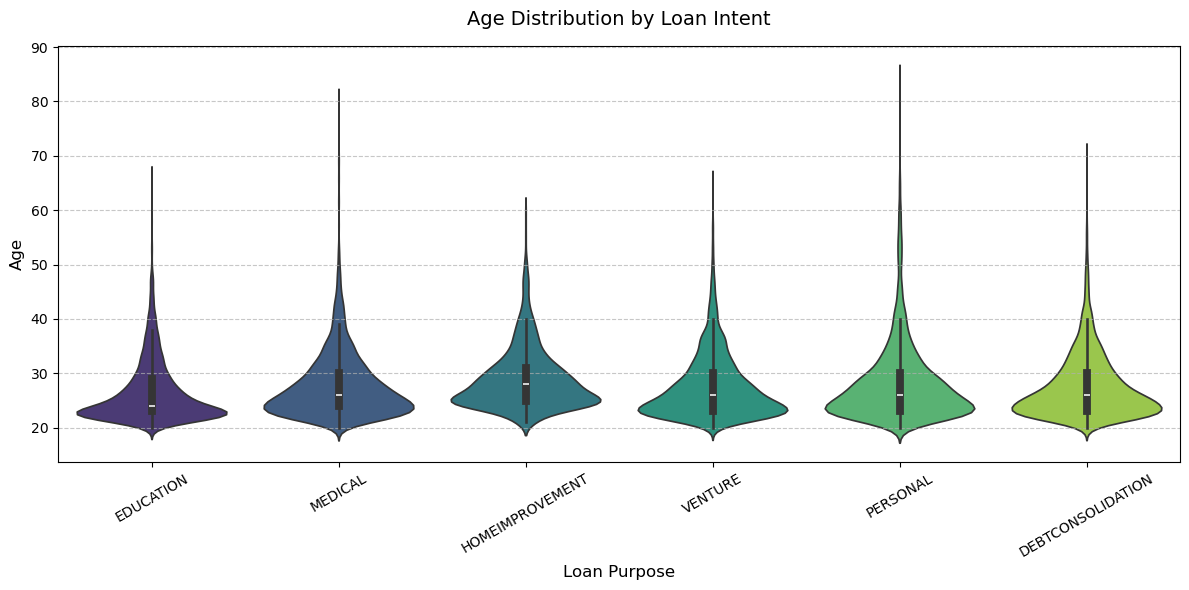

In [24]:
# Visualization #1
plt.figure(figsize=(12, 6))

sns.violinplot(data=df_train, 
               x='loan_intent', 
               y='person_age',
               hue='loan_intent',
               palette='viridis',
               inner='box') 

plt.title('Age Distribution by Loan Intent', pad=15, fontsize=14)
plt.xlabel('Loan Purpose', fontsize=12)
plt.ylabel('Age', fontsize=12)

plt.xticks(rotation=30)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

Figure 1. Shows how the distributions of loan intent vary by age. Medical and personal loans have the largest age spread and education seems to have the lowest median age.

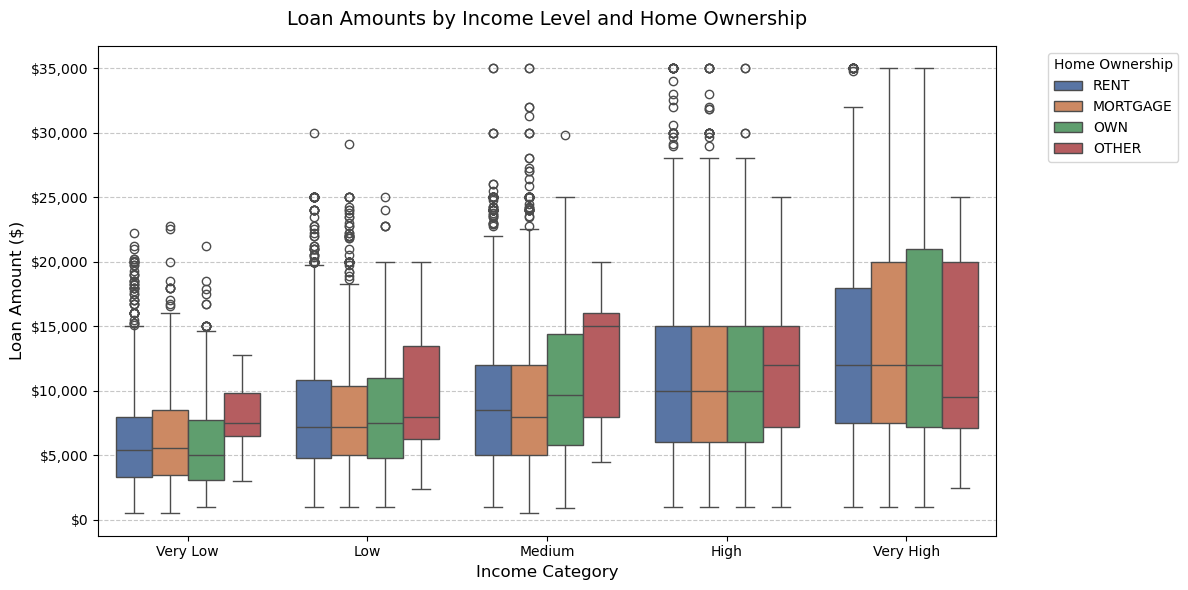

In [6]:
# Visualization #2
# Create income categories for better visualization
df_train['income_category'] = pd.qcut(df_train['person_income'], 
                                    q=5, 
                                    labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

plt.figure(figsize=(12, 6))

sns.boxplot(data=df_train, 
           x='income_category', 
           y='loan_amnt',
           hue='person_home_ownership',
           palette='deep')

plt.title('Loan Amounts by Income Level and Home Ownership', pad=15, fontsize=14)
plt.xlabel('Income Category', fontsize=12)
plt.ylabel('Loan Amount ($)', fontsize=12)

# format y-axis to show thousands
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Home Ownership', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

Figure 2. Shows loan amounts across different income levels and home ownership status, which can help us understand who gets access to larger loans. I created 5 income brackets (separated the income category into 5 categories) to help show which segments of perspective borrowers have access to larger loans. This gives us perspective on the magnitude of loans, giving us some insight into who might be more likely to default (for example, maybe the outliers in the "Very Low" bracket are likely to default, as they are quite largely above the median loan amount for the rest of their bracket).

### Build a Model

In [ ]:
from sklearn.preprocessing import LabelEncoder

df_train = df_train.drop(columns=['income_category'])

label_encoder = LabelEncoder()

qual_features = [
    'loan_intent',
    'cb_person_default_on_file'
]

for label in qual_features:
    df_train[label] = label_encoder.fit_transform(df_train[label])

df_train['person_home_ownership'] = df_train['person_home_ownership'].replace('OTHER', 0)
df_train['person_home_ownership'] = df_train['person_home_ownership'].replace('RENT', 1)
df_train['person_home_ownership'] = df_train['person_home_ownership'].replace('MORTGAGE', 2)
df_train['person_home_ownership'] = df_train['person_home_ownership'].replace('OWN', 3)

y_train = df_train["loan_status"]
X_train = df_train.drop(columns=['loan_status', 'loan_grade'])
X_train


/var/folders/3c/q12t83w527n5qwlh_p20k_t00000gn/T/ipykernel_831/3253817269.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train['person_home_ownership'] = df_train['person_home_ownership'].replace('OWN', 3)


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
1,27,98000,1,3.0,1,11750,13.47,0.12,1,6
2,22,36996,1,5.0,1,10000,7.51,0.27,0,4
3,24,26000,1,2.0,3,1325,12.87,0.05,0,4
4,29,53004,2,2.0,2,15000,9.63,0.28,0,10
6,21,21700,1,2.0,2,5500,14.91,0.25,0,2
...,...,...,...,...,...,...,...,...,...,...
26059,36,150000,2,8.0,1,3000,7.29,0.02,0,17
26060,23,48000,1,1.0,5,4325,5.42,0.09,0,4
26061,22,60000,1,0.0,3,15000,11.71,0.25,0,4
26062,30,144000,2,12.0,4,35000,12.68,0.24,0,8


### Find best features
Below I work to find the best features for our logistic regression model. I experimented with different numbers of features, and found that 2 features yielded the best results. I fit the logistic regression model with a cross-validation of 5 folds for each combination of features. 

In [8]:
# Find best features
from itertools import combinations
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

pd.set_option('max_colwidth', 10000)
num_features = 2

cols = X_train.columns

score_df_columns = ['features', 'score', 'weights']
score_df = pd.DataFrame(columns = score_df_columns)

for features in combinations(cols, num_features):
  features = list(features)
  
  LR = LogisticRegression(max_iter = 10000000000)
  LR.fit(X_train[features], y_train)  
  LRscore = cross_val_score(LR, X_train[features], y_train, cv = 5).mean()
  score_df.loc[len(score_df.index)] = [features, LRscore, LR.coef_]  

score_df = score_df.sort_values(by='score', ascending=False).head(5)
score_df

,features,score,weights
21,"[person_home_ownership, loan_percent_income]",0.848736,"[[-1.009688163139443, 8.271969139654322]]"
36,"[loan_amnt, loan_percent_income]",0.824071,"[[-6.038304758244034e-05, 10.192521499044894]]"
39,"[loan_int_rate, loan_percent_income]",0.823373,"[[0.28965363840490665, 8.41798717832072]]"
14,"[person_income, loan_percent_income]",0.822238,"[[-1.0897117986924622e-05, 7.210498494849672]]"
32,"[loan_intent, loan_percent_income]",0.819269,"[[-0.11082528287162276, 8.256012358077584]]"


As seen by the table above, the best two features are person_home_ownership and loan_percent_income. Now we can define our weights from these features.

In [9]:
# create weight array
w = score_df.iloc[0]["weights"][0]
w

array([-1.00968816,  8.27196914])

### Find a Threshold

In [10]:
# Start by defining X_train with the features found above
X_train = X_train[['person_home_ownership', 'loan_percent_income']]

model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

def linear_score(X, w):
    return X@w

s = linear_score(X_train, w)

# Calculate profit for repaid loans 
def profit_repaid(loan_amount, interest_rate):
    return loan_amount * (1 + 0.25 * interest_rate)**10 - loan_amount

# Calculate profit for defaulted loans
def profit_defaulted(loan_amount, interest_rate):
    return loan_amount * (1 + 0.25 * interest_rate)**3 - 1.7 * loan_amount


Our manipulated data:

In [11]:
X_train.head()

,person_home_ownership,loan_percent_income
1,1,0.12
2,1,0.27
3,1,0.05
4,2,0.28
6,1,0.25


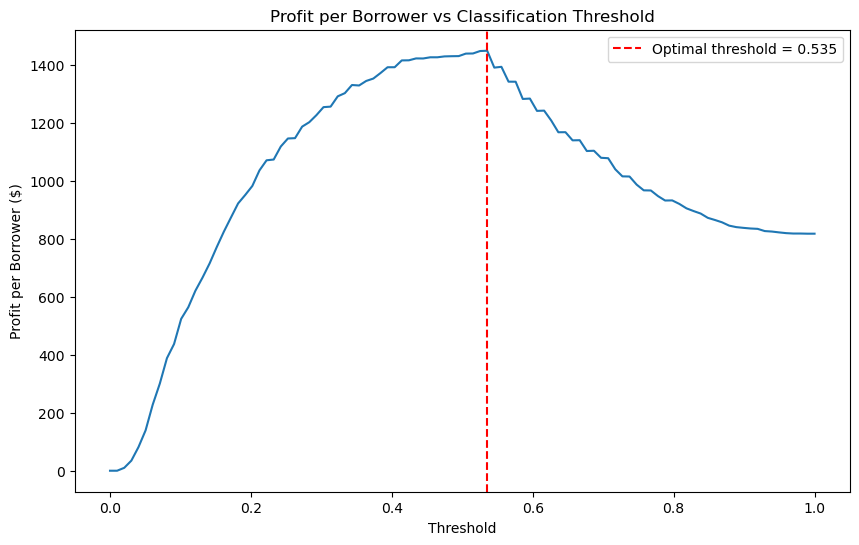

Optimal threshold: 0.535
Expected profit per borrower: $1,450.63

Confusion Matrix at Optimal Threshold:
[[17863   118]
 [ 3253  1673]]

Approval rate: 92.2%


In [ ]:
# Finding the optimal threshold
thresholds = np.linspace(0, 1, 100)
profits_per_borrower = []

# Get predicted probabilities from our model
# y_prob_train has the predicted probability of default for each loan in training set
y_prob_train = model.predict_proba(X_train)[:, 1] 

for threshold in thresholds:
    y_pred = (y_prob_train >= threshold)

    loan_amounts = df_train.loc[X_train.index, 'loan_amnt'] #get the loan amount for each loan in training set
    interest_rates = df_train.loc[X_train.index, 'loan_int_rate'] / 100 #convert to decimal

    # Calculate total profit (gains/losses)
    # For predicted repaid loans (y_pred == 0): we use profits_repaid
    # For predicted defaults (y_pred == 1): deny the loan, so profit is 0
    profits_repaid = profit_repaid(loan_amounts, interest_rates)
    profits_defaulted = profit_defaulted(loan_amounts, interest_rates)
    
    predicted_repay = (y_pred == 0)
    
    # only give loans to those predicted to repay
    # for those predicted to default, we don't give loans, so profit is 0
    total_profit = np.sum(profits_repaid * predicted_repay)
    
    # calculate what actually happens - some loans we approve will default (doesn't affect our decision making tho)
    actual_defaults = (y_train == 1)
    actual_repayments = (y_train == 0)
    
    # Calculate what we actually earn considering who actually defaults and who repays
    # Among approved loans (predicted_repay):
    # thosewho actually repay (actual_repayments): we get profits_repaid
    # those who actually default (actual_defaults): we get profits_defaulted
    actual_profit = np.sum(profits_repaid * (predicted_repay & actual_repayments)) + \
                    np.sum(profits_defaulted * (predicted_repay & actual_defaults))
    
    profit_per_borrower = actual_profit / len(X_train)
    profits_per_borrower.append(profit_per_borrower)

# get optimal threshold
optimal_threshold = thresholds[np.argmax(profits_per_borrower)]
max_profit_per_borrower = np.max(profits_per_borrower)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, profits_per_borrower)
plt.axvline(x=optimal_threshold, color='r', linestyle='--', 
            label=f'Optimal threshold = {optimal_threshold:.3f}')
plt.title('Profit per Borrower vs Classification Threshold')
plt.xlabel('Threshold')
plt.ylabel('Profit per Borrower ($)')
plt.grid(False)
plt.legend()
plt.show()

print(f"Optimal threshold: {optimal_threshold:.3f}")
print(f"Expected profit per borrower: ${max_profit_per_borrower:,.2f}")

# show confusion matrix at optimal threshold
y_pred_optimal = (y_prob_train >= optimal_threshold)
print("\nConfusion Matrix at Optimal Threshold:")
print(confusion_matrix(y_train, y_pred_optimal))

# show approval rate
approval_rate = np.mean(y_pred_optimal == 0) * 100
print(f"\nApproval rate: {approval_rate:.1f}%")



Figure 3. Shows the optimal threshold (profit maximizing) profit per borrower. 

### Evaluate the Model from the Bank’s Perspective

In [13]:
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/test.csv"
df_test = pd.read_csv(url)
df_test =df_test.dropna()

df_test['person_home_ownership'] = df_test['person_home_ownership'].replace('OTHER', 0)
df_test['person_home_ownership'] = df_test['person_home_ownership'].replace('RENT', 1)
df_test['person_home_ownership'] = df_test['person_home_ownership'].replace('MORTGAGE', 2)
df_test['person_home_ownership'] = df_test['person_home_ownership'].replace('OWN', 3)

X_test = df_test[['person_home_ownership', 'loan_percent_income']]

/var/folders/3c/q12t83w527n5qwlh_p20k_t00000gn/T/ipykernel_831/1276347050.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test['person_home_ownership'] = df_test['person_home_ownership'].replace('OWN', 3)


Test set approval rate: 91.6%

Confusion Matrix on Test Set:
[[4427   27]
 [ 824  453]]

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.84      0.99      0.91      4454
           1       0.94      0.35      0.52      1277

    accuracy                           0.85      5731
   macro avg       0.89      0.67      0.71      5731
weighted avg       0.87      0.85      0.82      5731


Expected profit per borrower on test set: $1,394.87


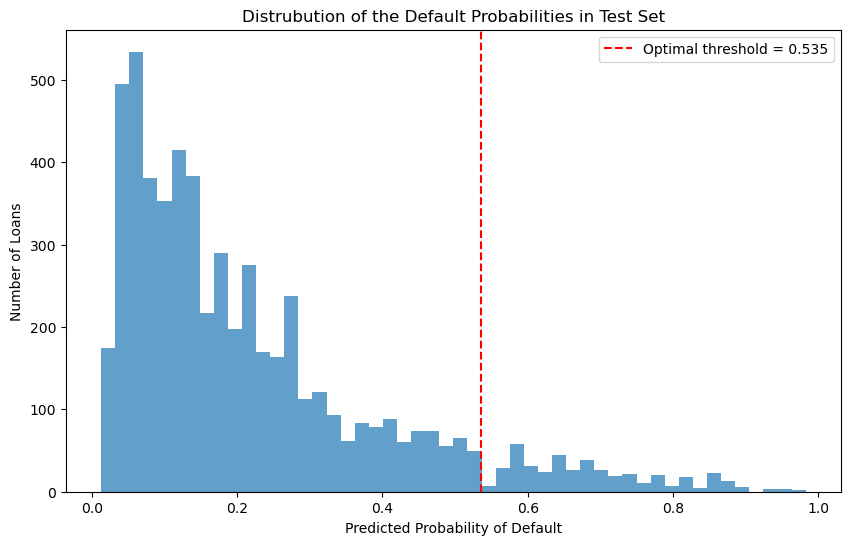

In [ ]:

y_prob_test = model.predict_proba(X_test)[:, 1]

y_pred_test = (y_prob_test >= optimal_threshold)

loan_amounts_test = df_test['loan_amnt']
interest_rates_test = df_test['loan_int_rate'] / 100

# Calculate potential profits for test loans
profits_repaid_test = profit_repaid(loan_amounts_test, interest_rates_test)
profits_defaulted_test = profit_defaulted(loan_amounts_test, interest_rates_test)

# Determine which loans we would approve
predicted_repay_test = (y_pred_test == 0)

# Calculate approval rate on test set
approval_rate_test = np.mean(predicted_repay_test) * 100
print(f"Test set approval rate: {approval_rate_test:.1f}%")

# If test set has actual outcomes (y_test), get performance
if 'loan_status' in df_test.columns:
    y_test = df_test['loan_status']
    
    # confusion matrix
    print("\nConfusion Matrix on Test Set:")
    print(confusion_matrix(y_test, y_pred_test))
    
    # calculate classification metrics
    print("\nClassification Report on Test Set:")
    print(classification_report(y_test, y_pred_test))
    
    # calculate actual profit on test set
    actual_defaults_test = (y_test == 1)
    actual_repayments_test = (y_test == 0)
    
    actual_profit_test = np.sum(profits_repaid_test * (predicted_repay_test & actual_repayments_test)) + \
                         np.sum(profits_defaulted_test * (predicted_repay_test & actual_defaults_test))
    
    profit_per_borrower_test = actual_profit_test / len(X_test)
    print(f"\nExpected profit per borrower on test set: ${profit_per_borrower_test:,.2f}")
else:
    # If we don't have actual outcomes, just calculate expected profit based on model predictions
    expected_profit = 0
    for i, prob in enumerate(y_prob_test):
        # Expected profit = (probability of repayment × profit if repaid) + 
        #                   (probability of default × profit if defaulted)
        if predicted_repay_test[i]:  # If we approve this loan
            expected_profit += (1-prob) * profits_repaid_test.iloc[i] + prob * profits_defaulted_test.iloc[i]
    
    expected_profit_per_borrower = expected_profit / len(X_test)
    print(f"\nExpected profit per borrower on test set (based on model probabilities): ${expected_profit_per_borrower:,.2f}")

plt.figure(figsize=(10, 6))
plt.hist(y_prob_test, bins=50, alpha=0.7)
plt.axvline(x=optimal_threshold, color='r', linestyle='--', 
            label=f'Optimal threshold = {optimal_threshold:.3f}')
plt.title('Distrubution of the Default Probabilities in Test Set')
plt.xlabel('Predicted Probability of Default')
plt.ylabel('Number of Loans')
plt.legend()
plt.grid(False)
plt.show()

The expected profit per borrower is $1,394.87. This is about $50 lower than the profit per borrower we predicted from the training set. The plot above shows the distribution of the predicted probabilities of defaulting in the test set and the number of loans given for each predicted probability. This is useful for understanding the ultimate duty of my model: as the probability of defaulting increases, we see the magnitude of loans given decreasing.

### Evaluate the Model From the Borrower’s Perspective

### Is it more difficult for people in certain age groups to access credit under your proposed system?

/var/folders/3c/q12t83w527n5qwlh_p20k_t00000gn/T/ipykernel_831/2054960233.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  approval_by_age = df_test.groupby('person_age_group')['approved'].mean()


Approval rates by age group:
person_age_group
<30      0.911374
30-50    0.930900
50-70    0.888889
70-90    0.500000
90+           NaN
Name: approved, dtype: float64


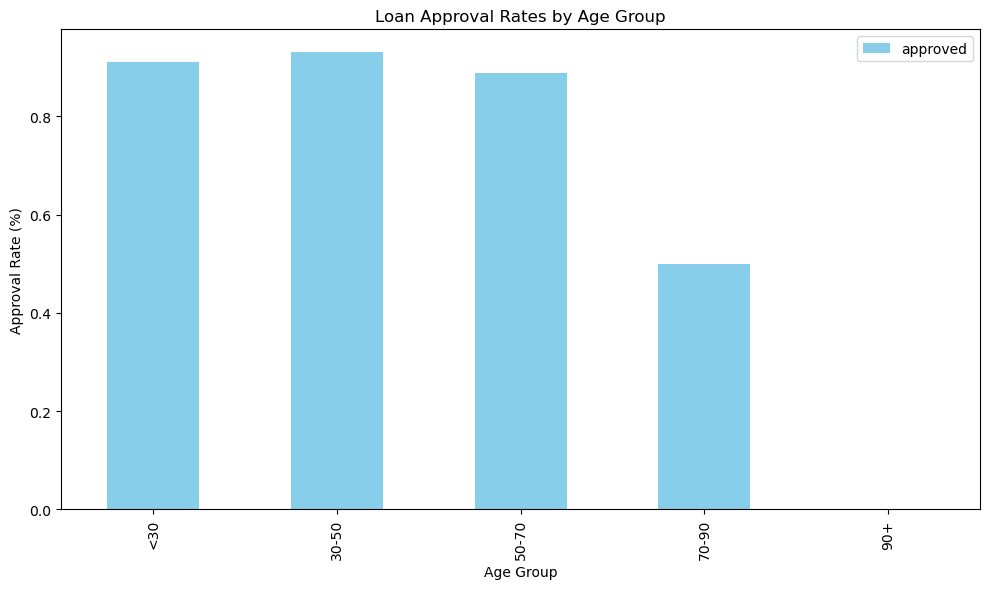

In [15]:
# create age groups
bins = [0, 30, 50, 70, 90, 150]
labels= ["<30", "30-50", "50-70", "70-90", "90+"]

df_test['person_age_group'] = pd.cut(df_test["person_age"], bins=bins, labels=labels, right=False)

df_test['expect_default'] = np.where(y_prob_test >= optimal_threshold, 1, 0)
df_test['approved'] = 1 - df_test['expect_default']

approval_by_age = df_test.groupby('person_age_group')['approved'].mean()

print("Approval rates by age group:")
print(approval_by_age)

plt.figure(figsize=(10, 6))
approval_by_age.plot(kind='bar', color='skyblue')
plt.title('Loan Approval Rates by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Approval Rate (%)')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

This plot shows that certain age groups have different approval rates. We see that ages under 70 have relatively similar approval rates, but a sharp decline for the 70-90 age range and a 0 approval rate for those over 90. This is an interesting finding and showcases that older individuals have a much harder time accessing credit.

[Text(0.5, 0, 'age'), Text(0, 0.5, 'count')]

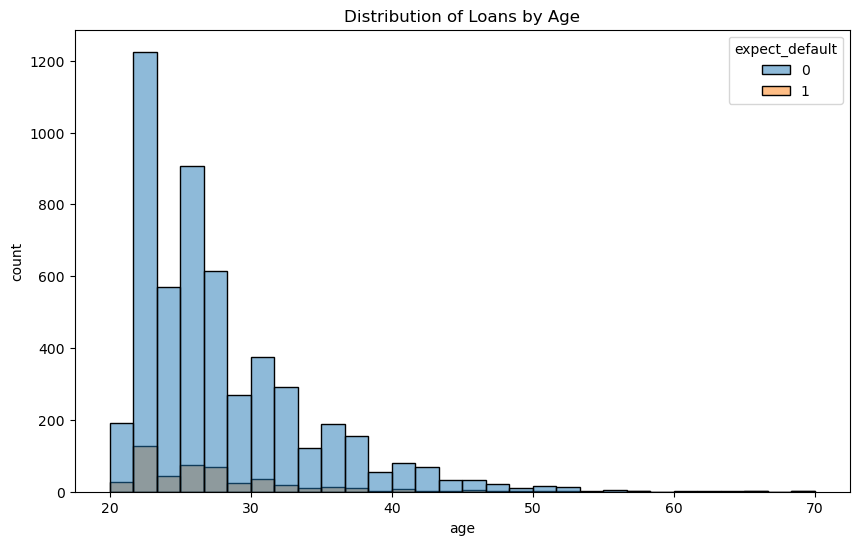

In [16]:
plt.figure(figsize=(10, 6))
plt.title("Distribution of Loans by Age")
sns.histplot(data = df_test, x = "person_age", hue = "expect_default", bins = 30).set(xlabel = "age", ylabel = "count")

Here we see the actual count of the distribution of loans by age. This is essentially showing the same info as the plot above, but giving a number to the loan counts. We see that the distribution of loans follows the distribution of predicting a default, which intuitively makes sense. This shows that approving a loan is less dependent on age and more dependent on the probability of defaulting. But, since our algorthim depends on the data, age groups' approval rates are biased by their age, not just their applicant status. 

### Is it more difficult for people to get loans in order to pay for medical expenses? How does this compare with the actual rate of default in that group? What about people seeking loans for business ventures or education?

In [17]:
# loan intent
analyze_loan_intent = df_test.groupby('loan_intent').agg({
    'approved': 'mean',
    'loan_status': 'mean'  # Actual default rate
}).reset_index()
analyze_loan_intent['approval_rate'] = analyze_loan_intent['approved'] * 100
analyze_loan_intent['default_rate'] = analyze_loan_intent['loan_status'] * 100
print(analyze_loan_intent[['loan_intent', 'approval_rate', 'default_rate']])

         loan_intent  approval_rate  default_rate
0  DEBTCONSOLIDATION      90.265487     28.761062
1          EDUCATION      92.346939     16.751701
2    HOMEIMPROVEMENT      96.103896     25.000000
3            MEDICAL      89.655172     28.424977
4           PERSONAL      91.182365     22.044088
5            VENTURE      91.804979     14.626556


Here we see the approval and default rates based on loan intent. Looking at the approval rates, medical loans do in fact have the lowest approval rate and the second highest actual rate of default. On the other hand, education hsa the second highest approval rate and the third highest actual rate of default. Venture loans have a similar approval rate but the lowest default rate. 

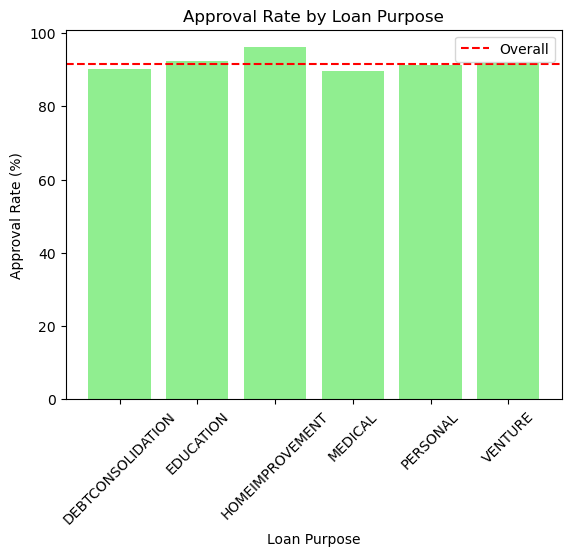

In [18]:
# Loan intent plot
plt.bar(analyze_loan_intent['loan_intent'], analyze_loan_intent['approval_rate'], color='lightgreen')
plt.axhline(y=df_test['approved'].mean() * 100, color='r', linestyle='--', label='Overall')
plt.title('Approval Rate by Loan Purpose')
plt.xlabel('Loan Purpose')
plt.ylabel('Approval Rate (%)')
plt.xticks(rotation=45)
plt.legend()

The plot above helps visualize the numerical values above. The red line shows the overall approval rate, and we see how different intents compare to that overall standard. To answer the question, different intents do indeed have different approval rates. 

### How does a person’s income level impact the ease with which they can access credit under your decision system?

In [19]:
# 3. Analyze by income level
df_test['income_category'] = pd.qcut(df_test['person_income'], 
                                    q=5, 
                                    labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
income_analysis = df_test.groupby('income_category').agg({
    'approved': 'mean',
    'loan_status': 'mean'  # Actual default rate
}).reset_index()
income_analysis['approval_rate'] = income_analysis['approved'] * 100
income_analysis['default_rate'] = income_analysis['loan_status'] * 100
print(income_analysis[['income_category', 'approval_rate', 'default_rate']])
print(f"Overall approval rate: {df_test['approved'].mean() * 100:.1f}%")


  income_category  approval_rate  default_rate
0        Very Low      80.625543     43.527368
1             Low      87.403599     23.736075
2          Medium      94.469224     18.822480
3            High      96.163906     14.995641
4       Very High      99.650655     10.131004
Overall approval rate: 91.6%


/var/folders/3c/q12t83w527n5qwlh_p20k_t00000gn/T/ipykernel_831/629915433.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_analysis = df_test.groupby('income_category').agg({


I created 5 income brackets to help show which segments of perspective borrowers have access to credit. Clearly wealth plays a role: the very high income bracket almost has a 100% approval rate, and the high bracket is not far behind. Going to the very low bracket, it is much lower (80%). It is important though to look at the actual default rates. While the approval rate for very low income is 20% lower than the very high income bracket, the actual default rate is notably 33% higher. So, the approval rate differs logically, except it is interesting how the gap between approval rates and actual default rates is not entirely linear.

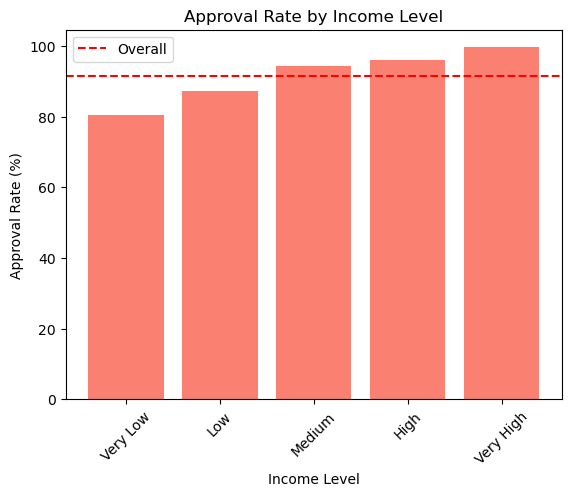

In [20]:
plt.bar(income_analysis['income_category'], income_analysis['approval_rate'], color='salmon')
plt.axhline(y=df_test['approved'].mean() * 100, color='r', linestyle='--', label='Overall')
plt.title('Approval Rate by Income Level')
plt.xlabel('Income Level')
plt.ylabel('Approval Rate (%)')
plt.xticks(rotation=45)
plt.legend()

A simple plot to display how approval rates differ by income level, compared to the overall approval rate.

### Concluding Thoughts
To goal of this blog post was to explore the impact of a purely profit-driven model on access to credit. So, I made an algorithm that works to make the most money for a bank. Consequently, I used the "best" features for modeling loan status and set a threshold value that offered loans to very few people – only those rated with a very low chance of default. These people, unsurprisingly, tended to have high income, be younger in age, and higher success getting a loan for home improvement than medical use. This is blatantly concerning and really delves into the deeper values of aid and capitalism. 

The people the the hypothetical bank is offering loans to are likely not in need of the loans as badly as the others. A home improvement project by a higher income individual seems magnitudially less crucial than a medical necessity.

Considering that people seeking loans for medical expenses have high rates of default, it may seem financially prudent to restrict their access to credit. However, this raises important ethical questions about whether our financial systems should prioritize profit over human welfare, especially when the need stems from unavoidable health crises rather than discretionary spending. So, in my opinion, I strongly value health over profit and thus the weight that we put on the probability of defualting should be lowered when regarding human welfare to give more loan access for medical needs.

Ultimately, this highlights the necessity to define what fairness and equity means in the context of model building. This sheds light on the ethics of model creating an algorithm by defining weights to features that are likely already inherently affected by systemic biases. 
